# Modelo de Baseline Supervisionado (SL) - Previsão de Lucro

**Objetivo:** Treinar um modelo de baseline (LGBM Regressor) para prever o `Lucro_Real` com base no contexto da campanha e nas features do produto digital.

**Metodologia:**
1.  **Carregar Artefatos:** Carrega o dataset (`.csv`) e os pré-processadores (`.joblib`) gerados pelo `Generator_NEW.py`.
2.  **Preparar Dados:** Define `X` (features) e `y` (alvo) e aplica os pré-processadores carregados (OHE, Scaler).
3.  **Treinar Modelo:** Divide os dados em treino/teste e treina um `LGBMRegressor`.
4.  **Avaliar (Global):** Calcula as métricas globais (MAE, RMSE, R²).
5.  **Avaliar (Granular):** Analisa o desempenho do modelo por segmentos (ex: `Tier`, `Tipo_Produto`).
6.  **Explicar (SHAP):** Usa SHAP para entender quais features mais impactam a previsão de lucro.

In [1]:
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
import shap
import d3rlpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

print("Carregando artefatos gerados pelo Generator...")

# encoder novo, gerado pelo Generator_NEW.py
encoder_sl = joblib.load("sl_ohe_encoder.joblib")

# scaler de estado – esse nome já bate com o generator
scaler_estado = joblib.load("sl_scaler_estado.joblib")

# se o generator salvou os dois alvos:
scaler_estado = joblib.load("sl_scaler_estado.joblib")
df_sl = pd.read_csv("sl_dataset_combined.csv")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Carregando artefatos gerados pelo Generator...

In [2]:
# 3) Ver quais features o encoder espera
print("\nFeatures que o encoder_sl viu no fit:")
print(list(encoder_sl.feature_names_in_))

print("\nColunas atuais do df_sl:")
print(list(df_sl.columns))


Features que o encoder_sl viu no fit:

['Regiao', 'Plataforma', 'Tier', 'Idade', 'Genero', 'Conteudo', 'Tipo_Produto', 'Modelo_Cobranca', 'Complexidade_Oferta']


Colunas atuais do df_sl:

['Regiao', 'Plataforma', 'Tier', 'Idade', 'Genero', 'Conteudo', 'Tipo_Produto', 'Modelo_Cobranca', 'Complexidade_Oferta', 'Orcamento', 'Preco_Amostra', 'Lucro_Real']

In [3]:
import sys
print(sys.executable)


C:\Users\MDF\Downloads\locac-main\project\.venv\Scripts\python.exe

In [4]:
# 4) Definir alvo e features EXATAMENTE com base no encoder
target_column = "Lucro_Real"   # é o lucro que queremos prever
feature_cols = list(encoder_sl.feature_names_in_)

# Garante que todas as features existem no dataset
missing = [c for c in feature_cols if c not in df_sl.columns]
if missing:
    raise ValueError(f"As seguintes colunas esperadas pelo encoder não existem no df_sl: {missing}")

X_raw = df_sl[feature_cols].copy()
y_raw = df_sl[target_column].values.reshape(-1, 1)

print(f"\nDimensões brutas:")
print(f"X_raw: {X_raw.shape}")
print(f"y_raw: {y_raw.shape}")


Dimensões brutas:

X_raw: (50000, 9)

y_raw: (50000, 1)

## 2. Preparar Dados (Definir X e y, Pré-processar)

In [5]:
print("\nAplicando pré-processamento (apenas encoder categórico)...")

# 1) One-hot nas 9 colunas categóricas
X_encoded = encoder_sl.transform(X_raw)

# 2) NÃO usar o scaler de estado por enquanto
X_processed = X_encoded

# 3) Alvo em R$ mesmo (sem scaler), mais simples e ótimo pro TCC
y_processed = y_raw

print(f"Formato final de X_processed: {X_processed.shape}")
print(f"Formato final de y_processed: {y_processed.shape}")

# Para SHAP: nomes das colunas após o one-hot
feature_names_processed = encoder_sl.get_feature_names_out()



Aplicando pré-processamento (apenas encoder categórico)...

Formato final de X_processed: (50000, 32)

Formato final de y_processed: (50000, 1)

## 3. Treinar Modelo (LGBMRegressor)

In [6]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.2, random_state=42
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste:  {X_test.shape[0]} amostras")

lgbm_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=31,
)

lgbm_model.fit(X_train, y_train.ravel())
print("✓ Modelo LGBM treinado.")


Treino: 40000 amostras

Teste:  10000 amostras

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Total Bins 64

[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 32

[LightGBM] [Info] Start training from score 16768.842466

✓ Modelo LGBM treinado.

## 4. Avaliar (Global)

Calcula as métricas e reverte o scaling para R$ (conforme snippet)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = lgbm_model.predict(X_test).reshape(-1, 1)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

r2 = r2_score(y_test, y_pred)

print("="*30)
print("MÉTRICAS GLOBAIS (Baseline SL)")
print("="*30)
print(f"MAE (R$):  {mae:,.2f}")
print(f"RMSE (R$): {rmse:,.2f}")
print(f"R²:        {r2:.2%}")


MÉTRICAS GLOBAIS (Baseline SL)

MAE (R$):  5,926.95

RMSE (R$): 9,631.15

R²:        72.50%


Calculando valores SHAP para explicabilidade...

✓ Valores SHAP calculados. Gerando gráfico de resumo...

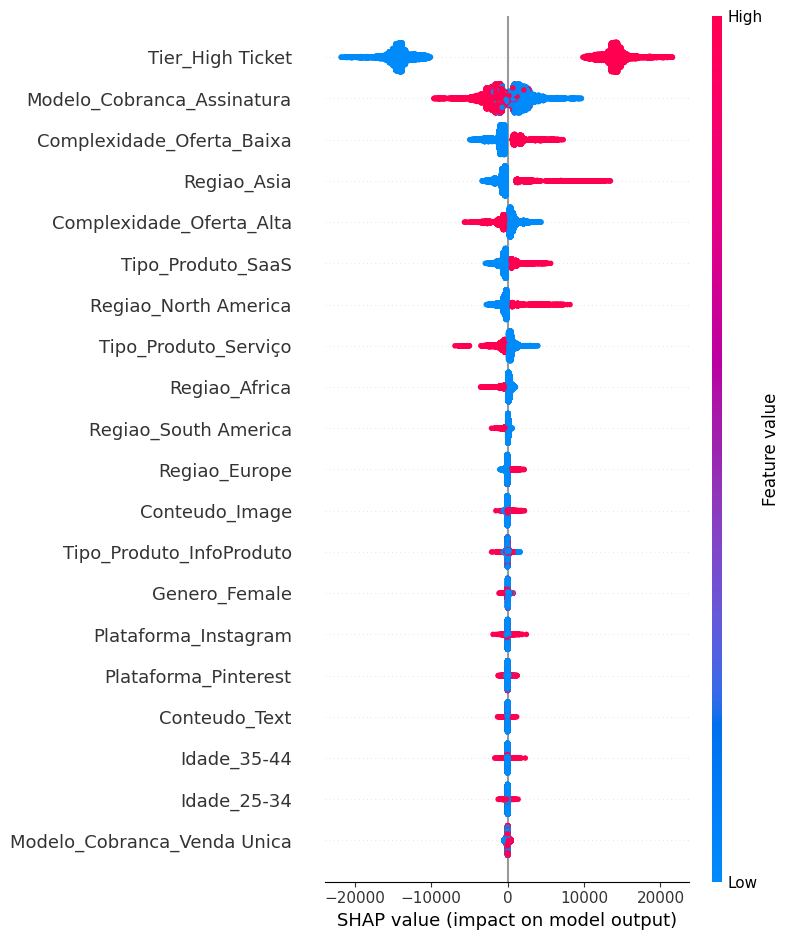

In [8]:
print("\nCalculando valores SHAP para explicabilidade...")

explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)

print("✓ Valores SHAP calculados. Gerando gráfico de resumo...")
shap.summary_plot(shap_values, X_test, feature_names=feature_names_processed)


## 6. Explicar (SHAP)

Análise de importância das features, conforme `prompt + alterações (1).pdf`.


Calculando valores SHAP para explicabilidade...

✓ Valores SHAP calculados. Gerando gráfico de resumo...

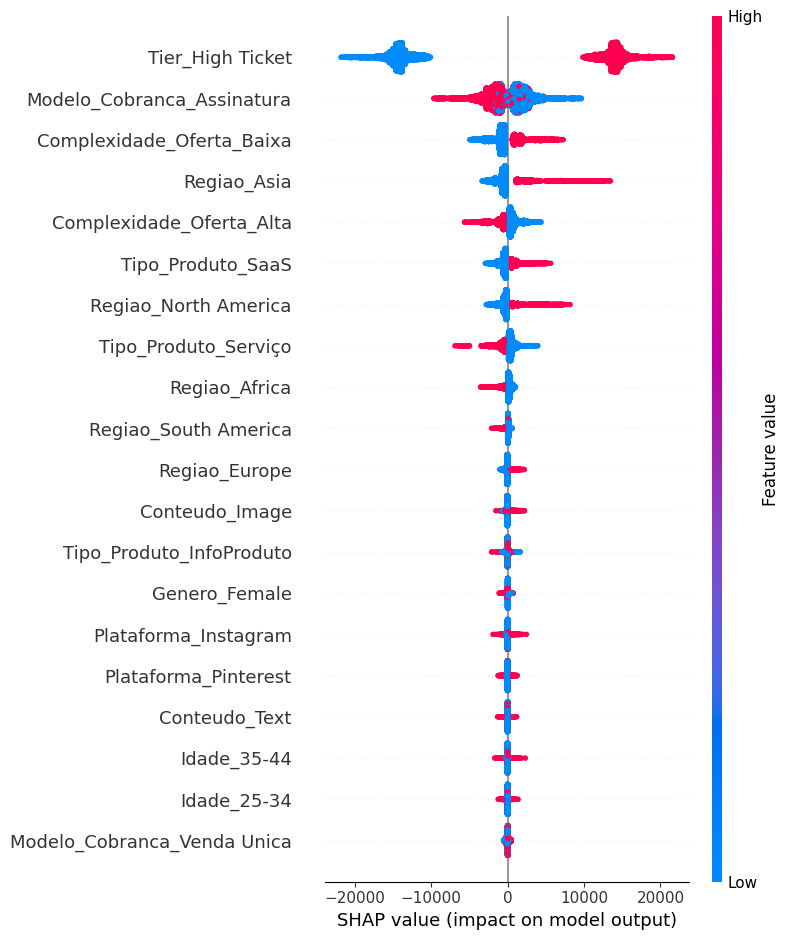

In [9]:
print("\nCalculando valores SHAP para explicabilidade...")

# 1. Criar o explicador
explainer = shap.TreeExplainer(lgbm_model)

# 2. Calcular os valores SHAP (usamos X_test processado)
shap_values = explainer.shap_values(X_test)

print("✓ Valores SHAP calculados. Gerando gráfico de resumo...")

# 3. Gerar o gráfico de resumo
# Note: Passamos X_test (processado) e os nomes das features (pós-processamento)
shap.summary_plot(shap_values, X_test, feature_names=feature_names_processed)